In [40]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

In [41]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

In [42]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


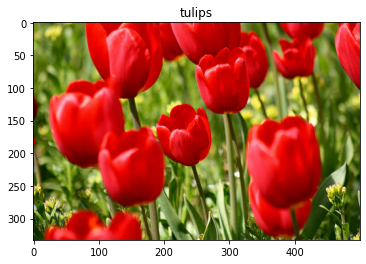

In [43]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [44]:
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255)
])

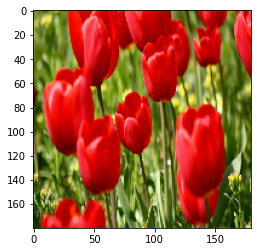

In [45]:
result = resize_and_rescale(image)
_ = plt.imshow(result)

In [46]:
print("Min and max pixel values:", result.numpy().min(), result.numpy().max())

Min and max pixel values: 0.0 1.0


In [47]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [48]:
# Add the image to a batch
image = tf.expand_dims(image, 0)

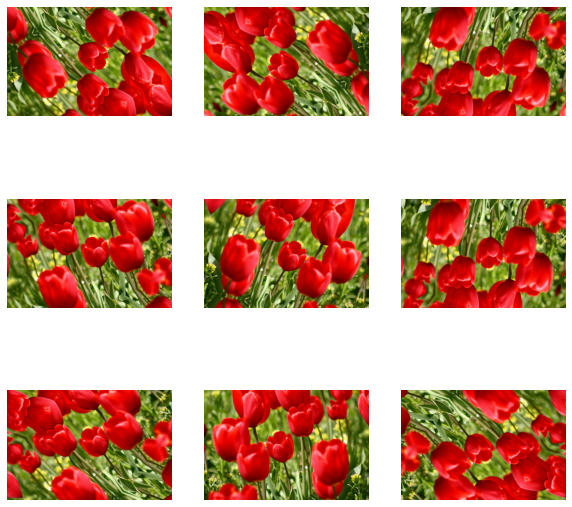

In [49]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

In [50]:
model = tf.keras.Sequential([
  resize_and_rescale,
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # Rest of your model
])

In [51]:
aug_ds = train_ds.map(
  lambda x, y: (resize_and_rescale(x, training=True), y))

In [52]:
batch_size = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefecting on all datasets
  return ds.prefetch(buffer_size=AUTOTUNE)

In [53]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

In [54]:
model = tf.keras.Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [55]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [56]:
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
92/92 [==============================] - 4s 33ms/step - loss: 1.4111 - accuracy: 0.3958 - val_loss: 1.1693 - val_accuracy: 0.4687
Epoch 2/5
92/92 [==============================] - 3s 26ms/step - loss: 1.0919 - accuracy: 0.5559 - val_loss: 1.0019 - val_accuracy: 0.6213
Epoch 3/5
92/92 [==============================] - 3s 27ms/step - loss: 0.9717 - accuracy: 0.6182 - val_loss: 0.9676 - val_accuracy: 0.6185
Epoch 4/5
92/92 [==============================] - 3s 27ms/step - loss: 0.9127 - accuracy: 0.6393 - val_loss: 0.8670 - val_accuracy: 0.6703
Epoch 5/5
92/92 [==============================] - 3s 26ms/step - loss: 0.8667 - accuracy: 0.6642 - val_loss: 0.8508 - val_accuracy: 0.6621


In [57]:
loss, acc = model.evaluate(test_ds)
print("Accuracy", acc)

12/12 [==============================] - 0s 8ms/step - loss: 0.8655 - accuracy: 0.6757
Accuracy 0.6757493019104004


In [58]:
def random_invert_img(x, p=0.5):
  if  tf.random.uniform([]) < p:
    x = (255-x)
  else:
    x
  return x

In [59]:
def random_invert(factor=0.5):
  return layers.Lambda(lambda x: random_invert_img(x, factor))

random_invert = random_invert()

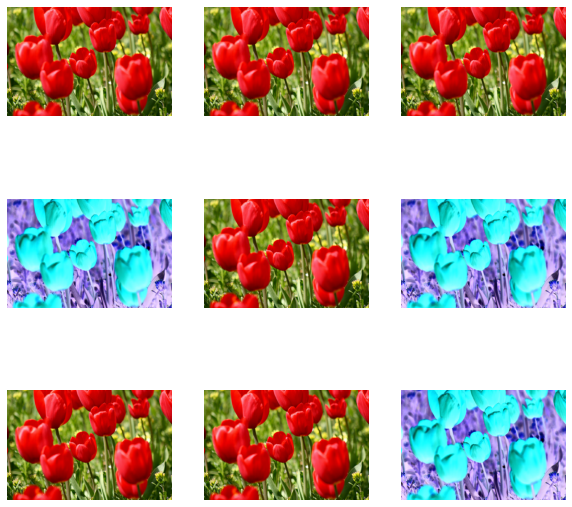

In [60]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = random_invert(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0].numpy().astype("uint8"))
  plt.axis("off")

In [61]:
class RandomInvert(layers.Layer):
  def __init__(self, factor=0.5, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor

  def call(self, x):
    return random_invert_img(x)

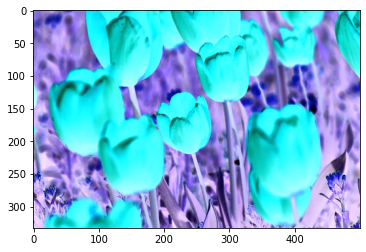

In [63]:
_ = plt.imshow(RandomInvert()(image)[0])

In [64]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

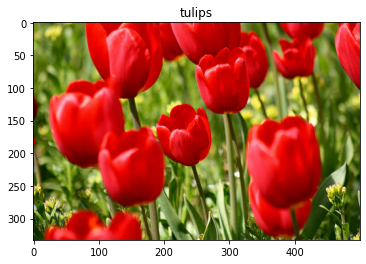

In [65]:
image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [66]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)

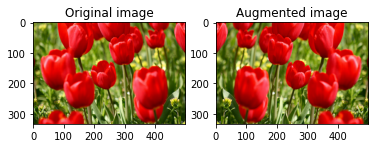

In [67]:
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

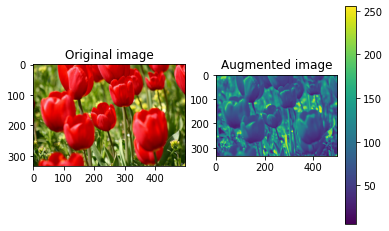

In [68]:
grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image, tf.squeeze(grayscaled))
_ = plt.colorbar()

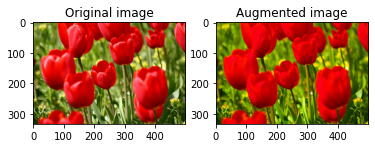

In [69]:
saturated = tf.image.adjust_saturation(image, 3)
visualize(image, saturated)

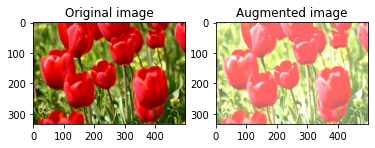

In [70]:
bright = tf.image.adjust_brightness(image, 0.4)
visualize(image, bright)

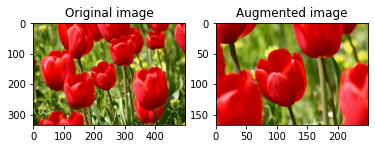

In [71]:
cropped = tf.image.central_crop(image, central_fraction=0.5)
visualize(image,cropped)

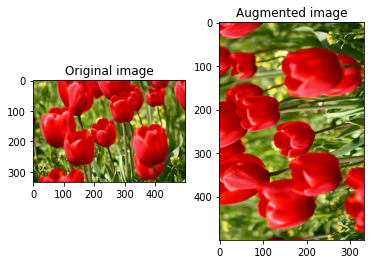

In [72]:
rotated = tf.image.rot90(image)
visualize(image, rotated)

In [73]:
def resize_and_rescale(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  image = (image / 255.0)
  return image, label

In [74]:
def augment(image,label):
  image, label = resize_and_rescale(image, label)
  # Add 6 pixels of padding
  image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE + 6, IMG_SIZE + 6) 
   # Random crop back to the original size
  image = tf.image.random_crop(image, size=[IMG_SIZE, IMG_SIZE, 3])
  image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness
  image = tf.clip_by_value(image, 0, 1)
  return image, label

In [75]:
train_ds = (
    train_ds
    .shuffle(1000)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [76]:
val_ds = (
    val_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [77]:
test_ds = (
    test_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)